# **The Stokes equations - adaptive mesh refinement**
**Lovisa Enblad**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations using adaptive mesh refinement, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with boundary conditions for $\partial \Omega = \Gamma_D \cup \Gamma_N \cup \Gamma_F$

$
u=g_D,\quad x\in \Gamma_D
$

$
u=0,\quad x\in \Gamma_F
$

$
-\nabla u\cdot n + pn = 0,\quad x\in \Gamma_N
$

Here $\Gamma_D$ is the part of the boundary where we prescribe Dirichlet boundary conditions, $\Gamma_N$ a part of the boundary where we apply a homogeneous Neumann boundary condition, and $\Gamma_F$ the part of the boundary over which we want to compute the force.

The weak (variational) form of the equations is: find a solution $(u,p)\in V\times Q$ such that

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) = (f,v)$

for all test functions $(v,q) \in \hat V \times Q$, where $\hat V$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(U,P)\in V_h\times Q_h$ such that

$- (P,\nabla \cdot v) + (\nabla U,\nabla v) + (\nabla \cdot U, q) = (f,v)$

for all test functions $(v,q) \in \hat V_h \times Q_h$, where $\hat V_h$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$. Here $V_h\subset V, Q_h\subset Q, \hat V_h\subset \hat V$ are finite dimensional subspaces defined over the computational mesh by finite element basis functions.

To implement the velocity Dirichlet boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, where $C>0$ is a constant and $h$ is the local mesh size. At the outflow a "do nothing" zero stress boundary condition is used, meaning that the boundary condition is enforced weakly by setting the boundary integral to zero.

We consider the linear functional $F:V\times Q\rightarrow {\mathbb R}$,

$F(v,q) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} + \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}$

corresponding to weighted mean values of $v$ and $q$, and the force on the surface $\Gamma_F\subset \partial \Omega$,
which generates the adjoint Stokes equations

$-\nabla \theta -\Delta \varphi = \psi_1,\quad -\nabla \cdot \varphi=\psi_2,$

together with boundary conditions that reflect the primal equations and the chosen functional.

$
\varphi=0,\quad x\in \Gamma_D
$

$
\varphi=\psi_3,\quad x\in \Gamma_F
$

$
- \nabla \varphi \cdot n - \theta n=0, \quad x\in \Gamma_N
$

The weak form of the adjoint Stokes equations take the form: find $(\varphi,\theta)\in \hat V\times Q$ such that

$- (q,\nabla \cdot \varphi) + (\nabla v,\nabla \varphi) + (\nabla \cdot v, \theta) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} - \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}= F(v,q)$

for all test functions $(v,q) \in V\times Q$.

Since the Stokes equations are linear we can express the error in the linear functional with respect to an approximation $(u,p)\approx (U,P)$ as

$F(u,p) - F(U,P) = (f,\varphi) + (P,\nabla \cdot \varphi) - (\nabla U,\nabla \varphi) - (\nabla \cdot U, \theta) = r(U,P;\varphi,\theta) = \sum_K {\mathcal E}_K$

where we used that $F(u,p)=(f,\varphi)$ since $\varphi \in \hat V$,
with the error indicator

${\mathcal E}_K = r(U,P;\varphi,\theta)\vert _K$,

which is the local residual on weak form with the solution to the adjoint equation as test function. The error indicator ${\mathcal E}_K$ can be used as an indicator for where to refine the mesh to reduce the global error as efficiently as possible.

Note however that since $(U,P)\in V\times Q$ is the solution of a Galerkin finite element method, if we use the approximation $(\varphi,\theta) \approx (\varphi_h,\theta_h) \in \hat V_h\times Q_h$, the error indicators sum to zero. Hence, this sum cannot be used as a stopping criterion for an adaptive algorithm. Instead we may use error estimates of the type

$
{\mathcal E}_K \leq C h_K  (\Vert \nabla \varphi_h \Vert_K + \Vert \nabla \theta_h\Vert_K) \Vert R(U,P)\Vert_K
$

where $R(U,P)=(R_1(U,P),R_2(U))$ is the residual of the equations in strong form, with

$
R_1(U,P) = f + \Delta U - \nabla P
$

$
R_2(U) = \nabla \cdot U
$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**The domain (mandatory assignment)**

We use the data to the adjoint problem which defines the functional equal to the drag force:

psi_1 = (0,0), psi_2 = 0 and psi_3 = (1,0)

Then we change the height of the domain to H=L, and move the center of the circle over the domain. We investigate how the adjoint solution and the local mesh refinement changes as a result. Four positions is investigated in each quadrant of the domain: (1,3), (3,3), (1,1) and (3,1).

**The functional (mandatory assignment)**

The data to the adjoint problem (psi_1, psi_2, psi_3) is changed to analyze how the adjoint solution and the local mesh refinement changed as a result. The size and position of the circle is held constant. Four set-ups are investigated:

1.   Focus on drag reduction: psi_1 = (1,0), psi_2 = 0 and psi_3 = (1,0)
2.   Emphasis on lift optimization: psi_1 = (0,1), psi_2 = 0 and psi_3 = (0,1)
1.   Heat transfer enhancement: psi_1 = (0,0), psi_2 = 1 and psi_3 = (0,0)


**The total error (extra assignment)**

With the same approximation spaces for the primal and the adjoint problem, the total error appears to be close to zero. This is a false conclusion, and a consequence of the fact that we approximate the exact adjoint solution with a finite element function in the test space of the primal problem, for which the weak form is zero (modulo errors from solving the algebraic system). We change the mixed finite element space of the adjoint equation such that the total error is not zero by increasing the polynomial order of the adjoint finite element spaces. Then we verify that the total error is reduced when you use a mesh with finer resolution.  

**Define domain and mesh**
We specify the domain based on one of the cases mentioned earlier and create a mesh with a size of 1/32 while shifting the circle's position and adjusting the data for the adjoint problem. We then explore the total error by varying the mesh size.

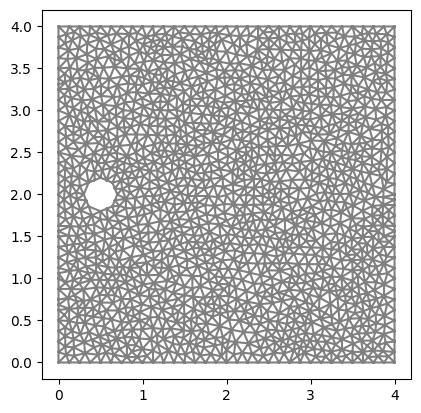

In [ ]:
# Define rectangular domain
L = 4
H = 4

# Define circle
xc = 0.5
yc = 0.5*H
rc = 0.2

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
init_no_levels = 0
for i in range(0,init_no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(0.5, 0.5)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**
We establish the function spaces for both the primal and adjoint problems to satisfy the inf-sup condition outlined in Theorem 8 in the Lecture 2 notes. We analyze the total error when using the same approximation spaces for both the primal and adjoint problems.

In [ ]:
# Generate mixed finite element spaces (for primal velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W)

# Generate mixed finite element spaces (for adjoint velocity and pressure)
VEa = VectorElement("CG", mesh.ufl_cell(), 4)
QEa = FiniteElement("CG", mesh.ufl_cell(), 2)
WEa = VEa * QEa

Wa = FunctionSpace(mesh, WEa)
Va = FunctionSpace(mesh, VEa)
Qa = FunctionSpace(mesh, QEa)

# Define adjoint trial and test functions
wa = Function(Wa)
(phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
(va, qa) = TestFunctions(Wa)

**Define boundary conditions**

In [ ]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element())
#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob), body boundary (bb) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element())
wb = Expression("near(x[1],YMIN) || near(x[1],YMAX) ? 1. : 0.", YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
bb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())

# **Results**

**Define and solve variational problems**
We establish the boundary conditions for the adjoint problem using three distinct weight functions, designated as ψ₁, ψ₂, and ψ₃. This approach allows for targeted mesh refinement based on velocity, pressure, drag, and lift considerations.

Next, we formulate both the primal problem and the adjoint problem in terms of their weak residual forms. This involves integrating the governing equations against the weight functions mentioned earlier. Once we have these formulations, we proceed by solving the systems of equations that arise.

In [ ]:
# Set boundary penalty parameter gamma
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

# Set force in primal problem
f = Expression(("0.0","0.0"), element = V.ufl_element())

# Set data that describe functional that defines the adjoint problem
#psi1 = Expression(("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-1.5,2)))","0.0"), element = V.ufl_element())
#psi2 = Expression("exp(-10.0(pow(x[0]-2.0,2) + pow(x[1]-1.0,2)))", element = Q.ufl_element())
psi1 = Expression(("0.0","0.0"), element = V.ufl_element())
psi2 = Expression("0.0", element = Q.ufl_element())
phi3 = Expression(("1.0","0.0"), element = V.ufl_element())

# Define primal variational problem on residual form: r(u,p;v,q) = 0
res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx +
        gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )

# Solve primal algebraic system
solve(res == 0, w)

# Define adjoint variational problem on residual form: r(u,p;v,q) = 0
res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx +
          gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - phi3, va))*ds
         - inner(va, psi1)*dx - qa*psi2*dx )

# Solve adjoint algebraic system
solve(res_a == 0, wa)

**Visualize solution and export files**

rm: cannot remove 'results-NS/*': No such file or directory


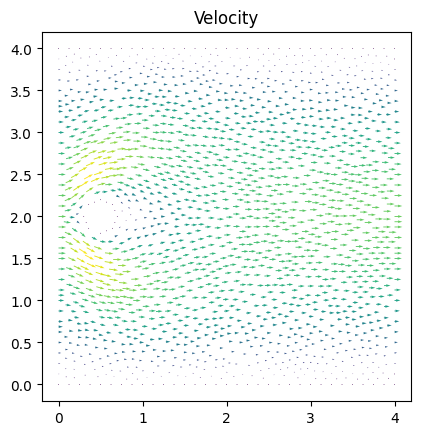

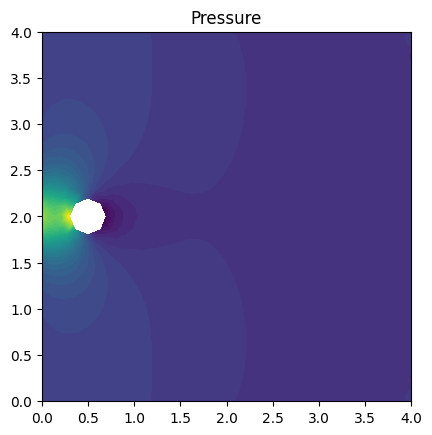

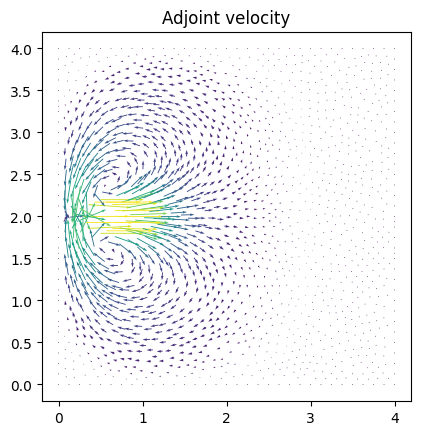

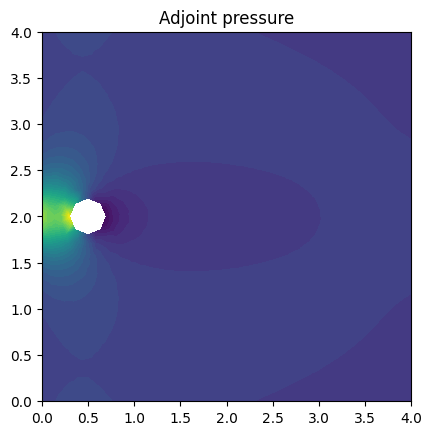

In [ ]:
!rm results-NS/*

# Open files to export solution to Paraview
file_u = File("results-Stokes/u.pvd")
file_p = File("results-Etokes/p.pvd")
file_phi = File("results-Stokes/phi.pvd")
file_theta = File("results-Etokes/theta.pvd")

# Initiate functions to save and visualize the solutions
u_fcn = project(u, V)
p_fcn = project(p, Q)
phi_fcn = project(phi, V)
theta_fcn = project(theta, Q)

# Save solution to file
file_u << u_fcn
file_p << p_fcn
file_phi << phi_fcn
file_theta << theta_fcn

# Plot solution
plt.figure()
plot(u_fcn, title="Velocity")

plt.figure()
plot(p_fcn, title="Pressure")

plt.figure()
plot(phi_fcn, title="Adjoint velocity")

plt.figure()
plot(theta_fcn, title="Adjoint pressure")

plt.show()

# Export files
#!tar -czvf results-Stokes.tar.gz results-NS
#files.download('results-Stokes.tar.gz')

**Compute error indicators**

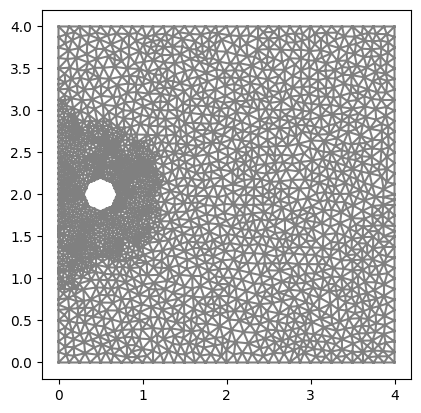

Total error = 0.016512345935784056


In [ ]:
# Define function space over the elements of the mesh
WDG = FunctionSpace(W.mesh(), "DG", 0)
elm = TestFunction(WDG)
err_ind = Function(WDG)

# Compute local error indicators over the cells of the mesh
local_error = ( elm*inner(f, phi)*dx + elm*p*div(phi)*dx - elm*inner(grad(u), grad(phi))*dx - elm*div(u)*theta*dx )
err_ind.vector()[:] = assemble(local_error)
err_ind_abs = np.abs(err_ind.vector())
err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for c in cells(mesh):
    cell_marker[c] = False
    local_error_cell = err_ind_abs[c.index()]
    if local_error_cell > err_ind_mean:
        cell_marker[c] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx -
               gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )

tot_err = assemble(err_ind_sum)
s = 'Total error = ' + repr(tot_err)
print(s)

**Figures**

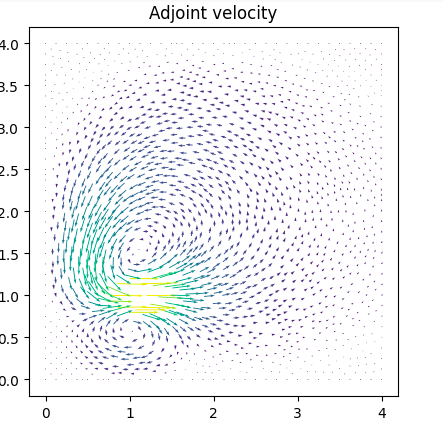

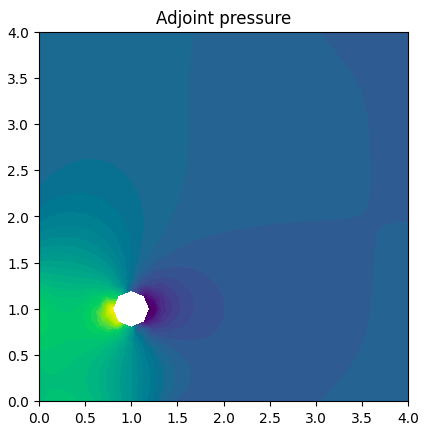

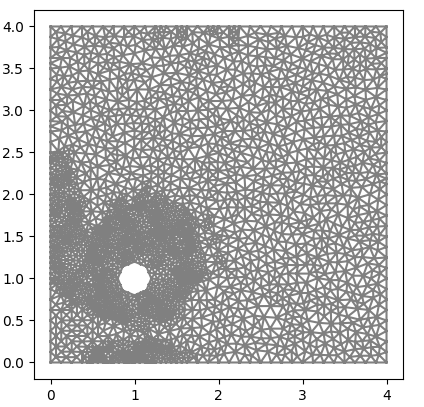

*Figure 1-3: Solution for circle in position (1,3)*

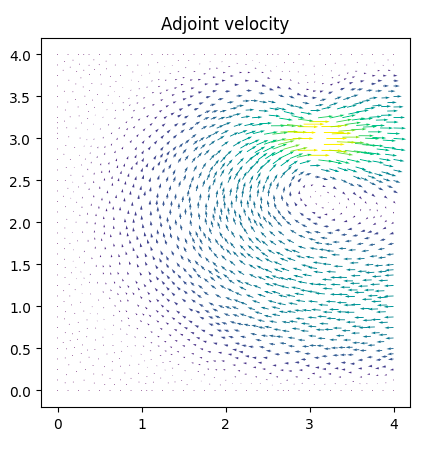

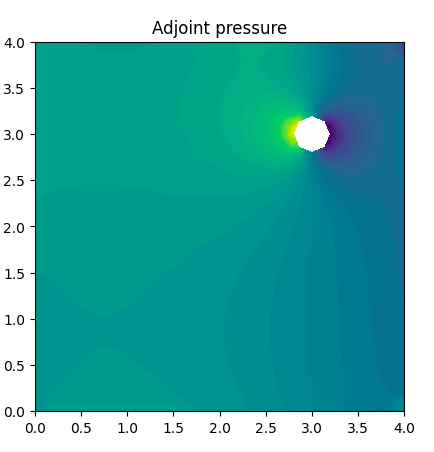

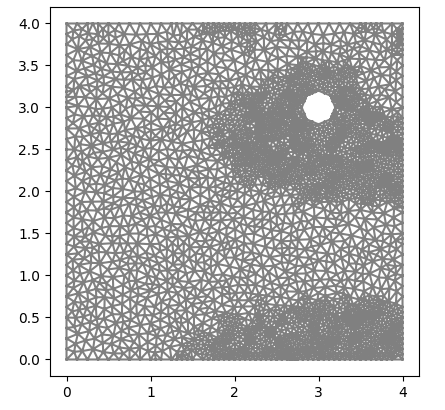

*Figure 4-6: Solution for circle in position (3,3)*

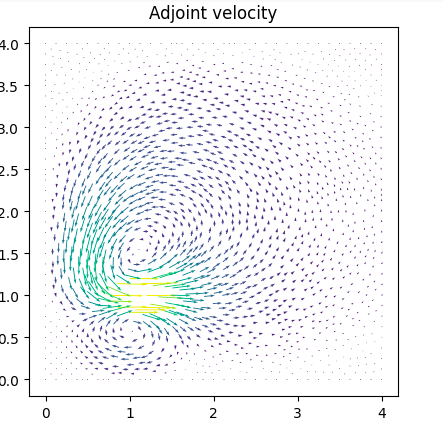

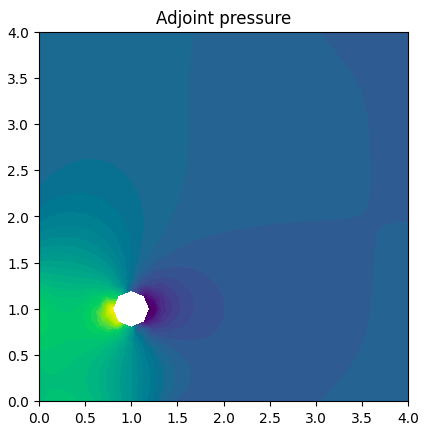

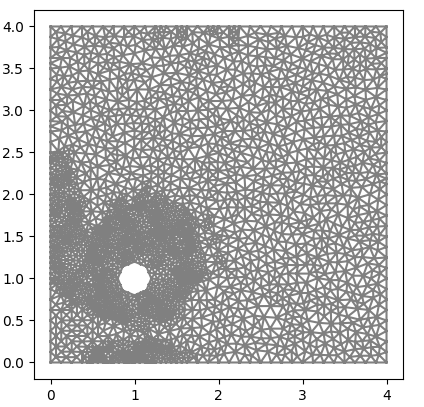

*Figure 7-9: Solution for circle in position (1,1)*

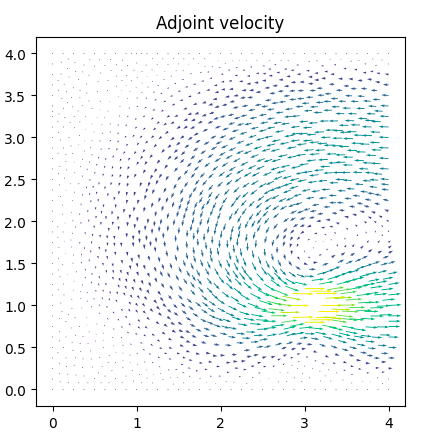

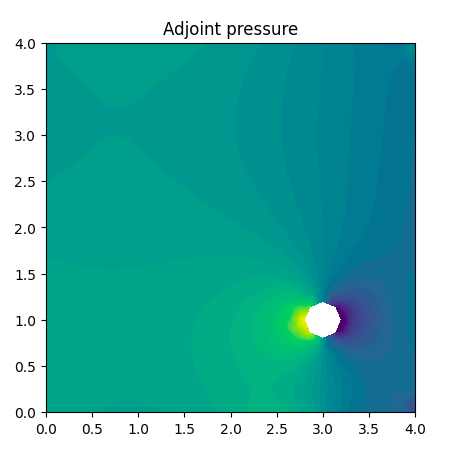

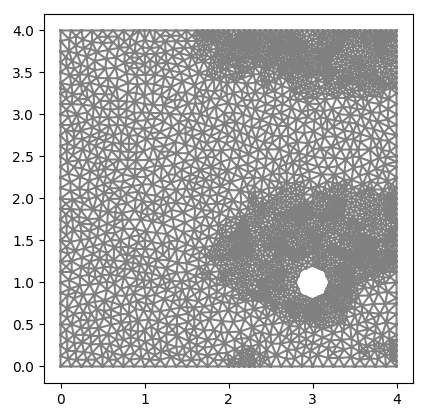

*Figure 10-12: Solution for circle in position (3,1)*

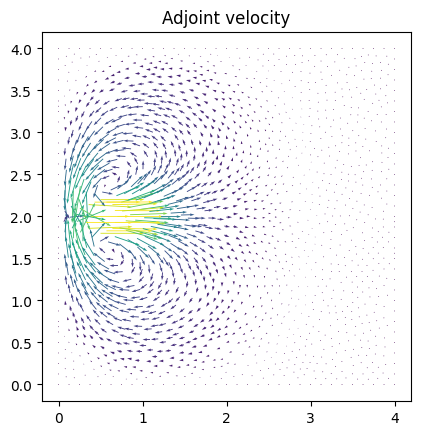

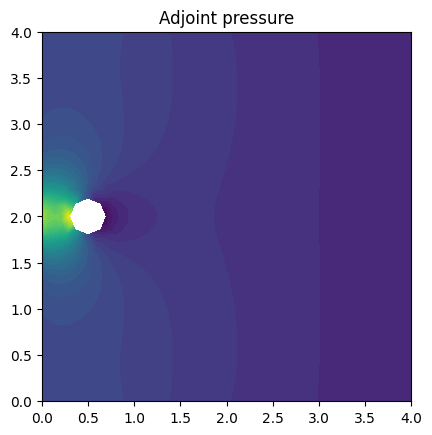

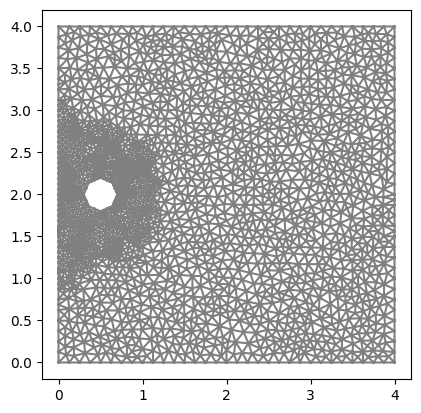

*Figure 13-15: Solution for set-up 1*

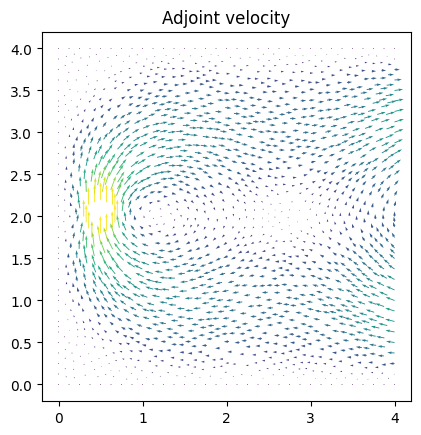

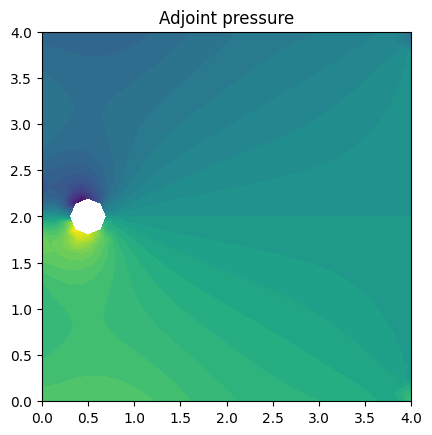

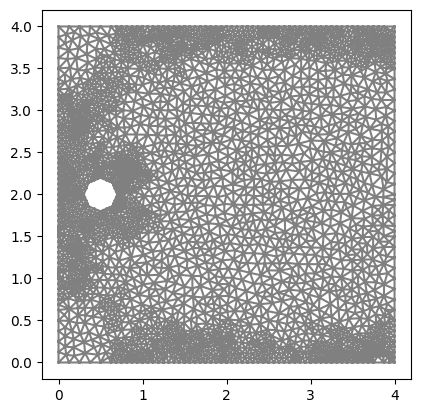

*Figure 16-18: Solution for set-up 2*

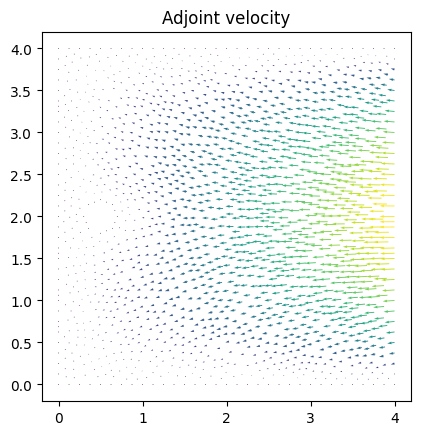

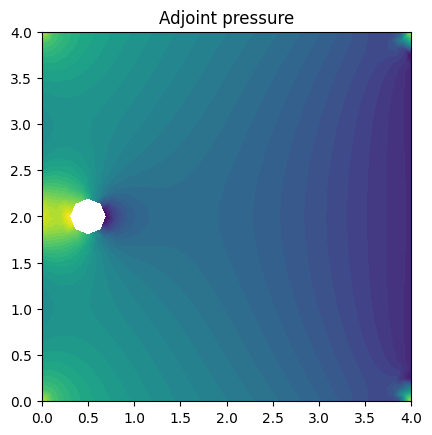

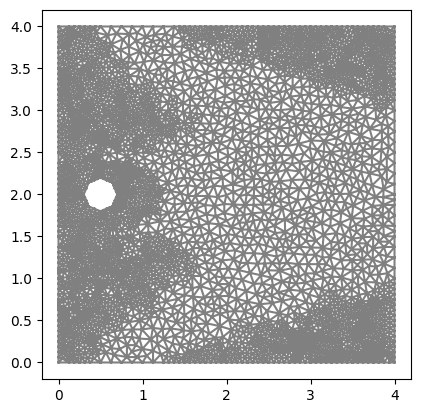

*Figure 19-21: Solution for set-up 3*

**The total error results**

**Resolultion:** 1/32

**Polynomial order:** 2 for VE and VEa and 1 for QE and QEa

**Total error:** -2.0248478458176344e-13

---

**Resolultion:** 1/32

**Polynomial order:** 2 for VE, 1 for QE, 4 for VEa and 2 for QEa

**Total error:** 0.016512345935784056

---

**Resolultion:** 1/50

**Polynomial order:** 2 for VE, 1 for QE, 4 for VEa and 2 for QEa

**Total error:** 0.004961046890147932

# **Discussion**

A adaptive finite element method was implemented in FEniCS to solve the Stokes equations in 2D. An adjoint problem was defined with respect to a chosen linear functional, after which the residual and the solution to the adjoint was used to define an error indicator over the mesh.

**The domain (mandatory assignment)**

For (1,3) and (1,1) the results are very similar. It is observed that the adjoint velocity demonstrates a similar shape around the circle and the adjoint pressure is highest to the just left of the circle tilted towards the nearest corner of the domain. The local mesh refinment cover the same portion of the total domain and is centered around the circle position and reaches the nearest edges with respect to the circle position.

The results for (3,3) and (3,1) are also similar. It is observed that the adjoint velocity demonstrates a similar shape around the circle and the adjoint pressure is highest just left of the circle tilted towards the left corner of the domain closest to the circle. The local mesh refinment covers the same portion of the total domain and is centered around the circle position. The local mesh refinement is also located in the right corner opposite to the circle. It was observed that the area with finer mesh is somewhat larger for (3,3) and (3,1) than (1,3) and (1,1).

**The functional (mandatory assignment)**

The data to the adjoint problem (psi_1, psi_2, psi_3) was changed to analyze how the adjoint solution and the local mesh refinement changed as a result. The size and position of the circle was held constant. Four set-ups were investigated:

1.   Focus on drag reduction: psi_1 = (1,0), psi_2 = 0 and psi_3 = (1,0)
2.   Emphasis on lift optimization: psi_1 = (0,1), psi_2 = 0 and psi_3 = (0,1)
1.   Heat transfer enhancement: psi_1 = (0,0), psi_2 = 1 and psi_3 = (0,0)


For set-up (1) the adjoint solution highlighted regions sensitive to changes in drag with high adjoint pressure right next to the circle to the left and with a similar shape of adjoint velocity as the reference set-up used in previous section. Mesh refinement was concentrated around the object and in the wake region where the sensitivity to drag alterations is highest.

As we change to set-up (2) the adjoint solution will be sensitive to vertical movements and flow separations affecting lift. The mesh refinement icreased around the upper and lower surfaces of the object to accurately capture the vertical force influences.

For set-up (3) the adjoint velocity solution vectors appear to have a uniform distribution in the x-direction across most of the domain with a significant increase in magnitude as they approach a specific location (the middle of the right edge of the domain), which appears to be the region of interest, possibly where a boundary condition or source term is applied. The uniformity suggests that there is a consistent influence across the domain, but the strength of the influence increases near that specific point. The adjoint pressure is highest right next to the circle to the left and in the left corners. The mesh refinement plot illustrates that there's a denser mesh concentration on the left side of the domain (including the circle) and in the right upper and lower corners.

**The total error (extra assignment)**

We start by applying the same polynomial order of the adjoint and primal finite element spaces (2 for VE and VEa and 1 for QE and QEa) and observe that the total error of -2.0248478458176344e-13 is close to zero. This is a false conclusion, and a consequence of the fact that we approximate the exact adjoint solution with a finite element function in the test space of the primal problem, for which the weak form is zero (modulo errors from solving the algebraic system).

To solve for this, we use higher polynomial order of the adjoint finite element spaces. Note that the program was set to 2 for VE, 1 for QE, 3 for VEa and 2 for QEa. We increase the approximation spaces for the adjoint solution even further (4 for VEa and 2 for QEa) as it will give a more exact total error since we have a more detailed and accurate representation of the adjoint fields and the exact error is the residual multiplied with the exact adjoint. One could of course increase these further but it will have a negative effect on computation time. With this set-up the error is 0.016512345935784056, hence, non-zero.

We then verify that the total error is reduced with a mesh of finer resolution. Previously, the resolution was set to 1/32 and we now apply a resolution of 1/50 which yields a total error of 0.004961046890147932 which is lower then with higher resolution. Finer mesh resolution allows for a more accurate approximation of the continuous problem by better capturing the local behavior and complexities of the solution within the domain resulting in a lower total error.